# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


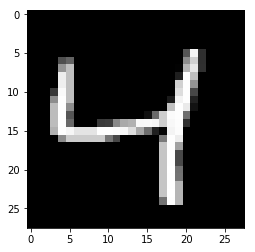

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

![Convolutional Autoencoder](assets/convolutional_autoencoder.png)

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **deconvolutional** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but it reverse. A stride in the input layer results in a larger stride in the deconvolutional layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a deconvolutional layer. Deconvolution is often called "transpose convolution" which is what you'll find with the TensorFlow API, with [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, deconvolutional layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor).

In [7]:
tf.layers.max_pooling2d?

In [16]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, shape=(None, 28,28,1)) #don't flatten! 
targets_ = tf.placeholder(tf.float32, shape=(None, 28,28,1)) #don't flatten! 

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (3,3), padding='SAME', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='SAME')
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), padding='SAME', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='SAME')
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 8, (3,3), padding='SAME', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='SAME')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7)) #iterpolate
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, (3,3), padding='SAME', activation=tf.nn.relu)
# Now 7x7x8
upsample2 =  tf.image.resize_nearest_neighbor(conv4, (14, 14)) #iterpolate
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='SAME', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28)) #iterpolate
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='SAME', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1 linear 

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here wi'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [17]:
sess = tf.Session()

In [18]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6713
Epoch: 1/20... Training loss: 0.6597
Epoch: 1/20... Training loss: 0.6458
Epoch: 1/20... Training loss: 0.6301
Epoch: 1/20... Training loss: 0.6087
Epoch: 1/20... Training loss: 0.5895
Epoch: 1/20... Training loss: 0.5682
Epoch: 1/20... Training loss: 0.5448
Epoch: 1/20... Training loss: 0.5252
Epoch: 1/20... Training loss: 0.5082
Epoch: 1/20... Training loss: 0.5061
Epoch: 1/20... Training loss: 0.5131
Epoch: 1/20... Training loss: 0.5088
Epoch: 1/20... Training loss: 0.5014
Epoch: 1/20... Training loss: 0.4986
Epoch: 1/20... Training loss: 0.4846
Epoch: 1/20... Training loss: 0.4614
Epoch: 1/20... Training loss: 0.4480
Epoch: 1/20... Training loss: 0.4427
Epoch: 1/20... Training loss: 0.4369
Epoch: 1/20... Training loss: 0.4293
Epoch: 1/20... Training loss: 0.4206
Epoch: 1/20... Training loss: 0.4088
Epoch: 1/20... Training loss: 0.4047
Epoch: 1/20... Training loss: 0.3954
Epoch: 1/20... Training loss: 0.3927
Epoch: 1/20... Training loss: 0.3738
E

Epoch: 1/20... Training loss: 0.1651
Epoch: 1/20... Training loss: 0.1684
Epoch: 1/20... Training loss: 0.1631
Epoch: 1/20... Training loss: 0.1696
Epoch: 1/20... Training loss: 0.1629
Epoch: 1/20... Training loss: 0.1672
Epoch: 1/20... Training loss: 0.1676
Epoch: 1/20... Training loss: 0.1547
Epoch: 1/20... Training loss: 0.1663
Epoch: 1/20... Training loss: 0.1606
Epoch: 1/20... Training loss: 0.1575
Epoch: 1/20... Training loss: 0.1589
Epoch: 1/20... Training loss: 0.1645
Epoch: 1/20... Training loss: 0.1608
Epoch: 1/20... Training loss: 0.1658
Epoch: 1/20... Training loss: 0.1578
Epoch: 1/20... Training loss: 0.1622
Epoch: 1/20... Training loss: 0.1631
Epoch: 1/20... Training loss: 0.1681
Epoch: 1/20... Training loss: 0.1525
Epoch: 1/20... Training loss: 0.1570
Epoch: 1/20... Training loss: 0.1579
Epoch: 1/20... Training loss: 0.1589
Epoch: 1/20... Training loss: 0.1551
Epoch: 1/20... Training loss: 0.1614
Epoch: 1/20... Training loss: 0.1596
Epoch: 1/20... Training loss: 0.1618
E

Epoch: 2/20... Training loss: 0.1388
Epoch: 2/20... Training loss: 0.1354
Epoch: 2/20... Training loss: 0.1401
Epoch: 2/20... Training loss: 0.1374
Epoch: 2/20... Training loss: 0.1330
Epoch: 2/20... Training loss: 0.1375
Epoch: 2/20... Training loss: 0.1363
Epoch: 2/20... Training loss: 0.1415
Epoch: 2/20... Training loss: 0.1413
Epoch: 2/20... Training loss: 0.1399
Epoch: 2/20... Training loss: 0.1384
Epoch: 2/20... Training loss: 0.1380
Epoch: 2/20... Training loss: 0.1367
Epoch: 2/20... Training loss: 0.1406
Epoch: 2/20... Training loss: 0.1361
Epoch: 2/20... Training loss: 0.1444
Epoch: 2/20... Training loss: 0.1375
Epoch: 2/20... Training loss: 0.1323
Epoch: 2/20... Training loss: 0.1318
Epoch: 2/20... Training loss: 0.1400
Epoch: 2/20... Training loss: 0.1411
Epoch: 2/20... Training loss: 0.1373
Epoch: 2/20... Training loss: 0.1373
Epoch: 2/20... Training loss: 0.1357
Epoch: 2/20... Training loss: 0.1419
Epoch: 2/20... Training loss: 0.1341
Epoch: 2/20... Training loss: 0.1361
E

Epoch: 3/20... Training loss: 0.1307
Epoch: 3/20... Training loss: 0.1271
Epoch: 3/20... Training loss: 0.1249
Epoch: 3/20... Training loss: 0.1303
Epoch: 3/20... Training loss: 0.1258
Epoch: 3/20... Training loss: 0.1283
Epoch: 3/20... Training loss: 0.1241
Epoch: 3/20... Training loss: 0.1265
Epoch: 3/20... Training loss: 0.1282
Epoch: 3/20... Training loss: 0.1266
Epoch: 3/20... Training loss: 0.1288
Epoch: 3/20... Training loss: 0.1282
Epoch: 3/20... Training loss: 0.1291
Epoch: 3/20... Training loss: 0.1279
Epoch: 3/20... Training loss: 0.1319
Epoch: 3/20... Training loss: 0.1230
Epoch: 3/20... Training loss: 0.1249
Epoch: 3/20... Training loss: 0.1300
Epoch: 3/20... Training loss: 0.1252
Epoch: 3/20... Training loss: 0.1301
Epoch: 3/20... Training loss: 0.1297
Epoch: 3/20... Training loss: 0.1293
Epoch: 3/20... Training loss: 0.1299
Epoch: 3/20... Training loss: 0.1250
Epoch: 3/20... Training loss: 0.1282
Epoch: 3/20... Training loss: 0.1256
Epoch: 3/20... Training loss: 0.1266
E

Epoch: 3/20... Training loss: 0.1205
Epoch: 3/20... Training loss: 0.1212
Epoch: 3/20... Training loss: 0.1196
Epoch: 3/20... Training loss: 0.1223
Epoch: 3/20... Training loss: 0.1236
Epoch: 3/20... Training loss: 0.1207
Epoch: 3/20... Training loss: 0.1212
Epoch: 3/20... Training loss: 0.1202
Epoch: 3/20... Training loss: 0.1263
Epoch: 3/20... Training loss: 0.1204
Epoch: 3/20... Training loss: 0.1197
Epoch: 3/20... Training loss: 0.1223
Epoch: 4/20... Training loss: 0.1217
Epoch: 4/20... Training loss: 0.1236
Epoch: 4/20... Training loss: 0.1212
Epoch: 4/20... Training loss: 0.1193
Epoch: 4/20... Training loss: 0.1236
Epoch: 4/20... Training loss: 0.1274
Epoch: 4/20... Training loss: 0.1203
Epoch: 4/20... Training loss: 0.1176
Epoch: 4/20... Training loss: 0.1224
Epoch: 4/20... Training loss: 0.1247
Epoch: 4/20... Training loss: 0.1201
Epoch: 4/20... Training loss: 0.1164
Epoch: 4/20... Training loss: 0.1249
Epoch: 4/20... Training loss: 0.1175
Epoch: 4/20... Training loss: 0.1205
E

Epoch: 4/20... Training loss: 0.1186
Epoch: 4/20... Training loss: 0.1198
Epoch: 4/20... Training loss: 0.1114
Epoch: 4/20... Training loss: 0.1197
Epoch: 4/20... Training loss: 0.1162
Epoch: 4/20... Training loss: 0.1173
Epoch: 4/20... Training loss: 0.1146
Epoch: 4/20... Training loss: 0.1170
Epoch: 4/20... Training loss: 0.1149
Epoch: 4/20... Training loss: 0.1180
Epoch: 4/20... Training loss: 0.1188
Epoch: 4/20... Training loss: 0.1154
Epoch: 4/20... Training loss: 0.1196
Epoch: 4/20... Training loss: 0.1124
Epoch: 4/20... Training loss: 0.1162
Epoch: 4/20... Training loss: 0.1207
Epoch: 4/20... Training loss: 0.1232
Epoch: 4/20... Training loss: 0.1209
Epoch: 4/20... Training loss: 0.1171
Epoch: 4/20... Training loss: 0.1131
Epoch: 4/20... Training loss: 0.1171
Epoch: 4/20... Training loss: 0.1179
Epoch: 4/20... Training loss: 0.1224
Epoch: 4/20... Training loss: 0.1144
Epoch: 4/20... Training loss: 0.1164
Epoch: 4/20... Training loss: 0.1196
Epoch: 4/20... Training loss: 0.1195
E

Epoch: 5/20... Training loss: 0.1161
Epoch: 5/20... Training loss: 0.1186
Epoch: 5/20... Training loss: 0.1141
Epoch: 5/20... Training loss: 0.1183
Epoch: 5/20... Training loss: 0.1140
Epoch: 5/20... Training loss: 0.1138
Epoch: 5/20... Training loss: 0.1124
Epoch: 5/20... Training loss: 0.1125
Epoch: 5/20... Training loss: 0.1133
Epoch: 5/20... Training loss: 0.1192
Epoch: 5/20... Training loss: 0.1129
Epoch: 5/20... Training loss: 0.1159
Epoch: 5/20... Training loss: 0.1188
Epoch: 5/20... Training loss: 0.1172
Epoch: 5/20... Training loss: 0.1190
Epoch: 5/20... Training loss: 0.1152
Epoch: 5/20... Training loss: 0.1149
Epoch: 5/20... Training loss: 0.1196
Epoch: 5/20... Training loss: 0.1127
Epoch: 5/20... Training loss: 0.1125
Epoch: 5/20... Training loss: 0.1170
Epoch: 5/20... Training loss: 0.1185
Epoch: 5/20... Training loss: 0.1174
Epoch: 5/20... Training loss: 0.1189
Epoch: 5/20... Training loss: 0.1125
Epoch: 5/20... Training loss: 0.1148
Epoch: 5/20... Training loss: 0.1168
E

Epoch: 6/20... Training loss: 0.1143
Epoch: 6/20... Training loss: 0.1112
Epoch: 6/20... Training loss: 0.1162
Epoch: 6/20... Training loss: 0.1174
Epoch: 6/20... Training loss: 0.1140
Epoch: 6/20... Training loss: 0.1152
Epoch: 6/20... Training loss: 0.1111
Epoch: 6/20... Training loss: 0.1122
Epoch: 6/20... Training loss: 0.1149
Epoch: 6/20... Training loss: 0.1090
Epoch: 6/20... Training loss: 0.1136
Epoch: 6/20... Training loss: 0.1064
Epoch: 6/20... Training loss: 0.1148
Epoch: 6/20... Training loss: 0.1125
Epoch: 6/20... Training loss: 0.1114
Epoch: 6/20... Training loss: 0.1108
Epoch: 6/20... Training loss: 0.1110
Epoch: 6/20... Training loss: 0.1148
Epoch: 6/20... Training loss: 0.1109
Epoch: 6/20... Training loss: 0.1125
Epoch: 6/20... Training loss: 0.1163
Epoch: 6/20... Training loss: 0.1136
Epoch: 6/20... Training loss: 0.1146
Epoch: 6/20... Training loss: 0.1149
Epoch: 6/20... Training loss: 0.1141
Epoch: 6/20... Training loss: 0.1067
Epoch: 6/20... Training loss: 0.1165
E

KeyboardInterrupt: 

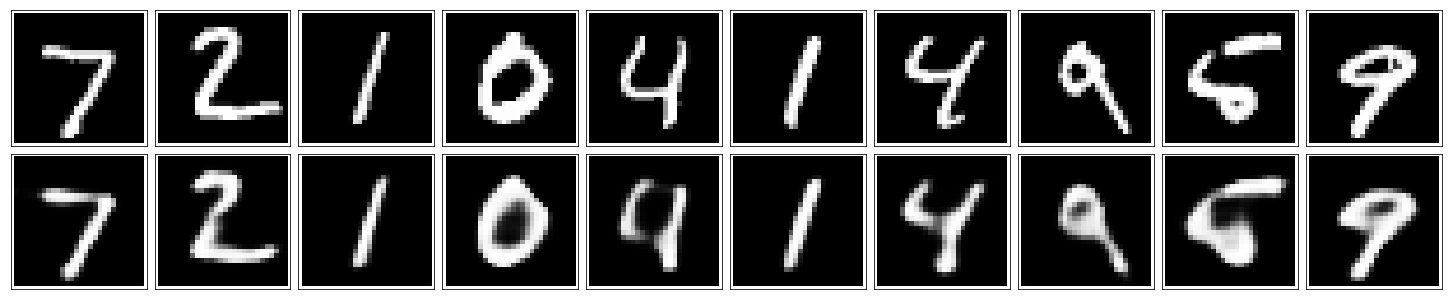

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [20]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [21]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, shape=(None, 28,28,1)) #don't flatten! 
targets_ = tf.placeholder(tf.float32, shape=(None, 28,28,1)) #don't flatten! 

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='SAME', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='SAME')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (3,3), padding='SAME', activation=tf.nn.relu)
# Now 14x1432
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='SAME')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='SAME', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='SAME')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7)) #iterpolate
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='SAME', activation=tf.nn.relu)
# Now 7x7x16
upsample2 =  tf.image.resize_nearest_neighbor(conv4, (14, 14)) #iterpolate
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding='SAME', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28)) #iterpolate
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='SAME', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1 linear 

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [22]:
sess = tf.Session()

In [23]:
epochs = 1
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/1... Training loss: 0.6847
Epoch: 1/1... Training loss: 0.6601
Epoch: 1/1... Training loss: 0.6240
Epoch: 1/1... Training loss: 0.5770
Epoch: 1/1... Training loss: 0.5252
Epoch: 1/1... Training loss: 0.4892
Epoch: 1/1... Training loss: 0.4937
Epoch: 1/1... Training loss: 0.5114
Epoch: 1/1... Training loss: 0.4958
Epoch: 1/1... Training loss: 0.4611
Epoch: 1/1... Training loss: 0.4484
Epoch: 1/1... Training loss: 0.4330
Epoch: 1/1... Training loss: 0.4421
Epoch: 1/1... Training loss: 0.4275
Epoch: 1/1... Training loss: 0.4257
Epoch: 1/1... Training loss: 0.4136
Epoch: 1/1... Training loss: 0.4138
Epoch: 1/1... Training loss: 0.4009
Epoch: 1/1... Training loss: 0.3798
Epoch: 1/1... Training loss: 0.3591
Epoch: 1/1... Training loss: 0.3529
Epoch: 1/1... Training loss: 0.3516
Epoch: 1/1... Training loss: 0.3389
Epoch: 1/1... Training loss: 0.3407
Epoch: 1/1... Training loss: 0.3249
Epoch: 1/1... Training loss: 0.3108
Epoch: 1/1... Training loss: 0.3035
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1814
Epoch: 1/1... Training loss: 0.1754
Epoch: 1/1... Training loss: 0.1786
Epoch: 1/1... Training loss: 0.1826
Epoch: 1/1... Training loss: 0.1777
Epoch: 1/1... Training loss: 0.1745
Epoch: 1/1... Training loss: 0.1815
Epoch: 1/1... Training loss: 0.1775
Epoch: 1/1... Training loss: 0.1777
Epoch: 1/1... Training loss: 0.1719
Epoch: 1/1... Training loss: 0.1764
Epoch: 1/1... Training loss: 0.1751
Epoch: 1/1... Training loss: 0.1743
Epoch: 1/1... Training loss: 0.1738
Epoch: 1/1... Training loss: 0.1824
Epoch: 1/1... Training loss: 0.1748
Epoch: 1/1... Training loss: 0.1763
Epoch: 1/1... Training loss: 0.1723
Epoch: 1/1... Training loss: 0.1742
Epoch: 1/1... Training loss: 0.1763
Epoch: 1/1... Training loss: 0.1785
Epoch: 1/1... Training loss: 0.1703
Epoch: 1/1... Training loss: 0.1794
Epoch: 1/1... Training loss: 0.1765
Epoch: 1/1... Training loss: 0.1731
Epoch: 1/1... Training loss: 0.1810
Epoch: 1/1... Training loss: 0.1759
Epoch: 1/1... Training loss:

KeyboardInterrupt: 

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

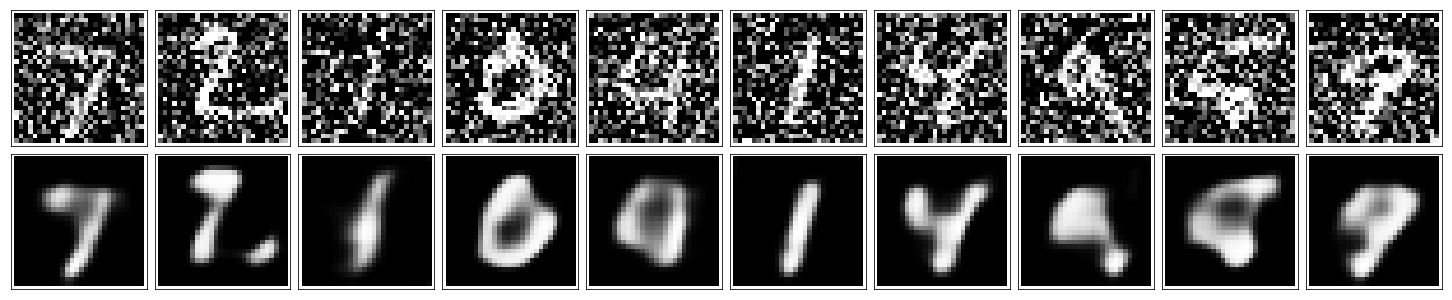

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)